# Analyse de la performance d’une stratégie GARP (Growth at a Reasonable Price)

**Master 2 Finance Internationale**

Objectif :
Analyser la performance d’une stratégie de conviction GARP, en décomposant l’alpha,
et en évaluant la persistance du couple rendement–risque face à des benchmarks mondiaux.


In [1]:
# =========================
# INSTALLATION DES PACKAGES
# =========================

! pip install pandas numpy yfinance matplotlib seaborn statsmodels openpyxl scikit-learn


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 52.7 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 75.2 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 69.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 62.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 72.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 79.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 70.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 73.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 75.7 MB/s  0:00:006m0:00:01
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15635

## 1. Préparation des données - Portefeuille GARP

Cette section vise à importer, nettoyer et harmoniser les données nécessaires à l’analyse empirique :
- Actions du portefeuille GARP (Yahoo Finance)
- Devise homogène : EUR
- Fréquence : mensuelle


In [7]:
# ======================================================
# 1. PREPARATION DES DONNEES – PORTEFEUILLE GARP
# ======================================================

# ----------------------
# 1.1 Librairies
# ----------------------
import pandas as pd
import numpy as np
import yfinance as yf
from pathlib import Path


# ----------------------
# 1.2 Univers d’investissement
# ----------------------
# Portefeuille GARP composé de 10 actions internationales
# La devise associée à chaque titre est précisée afin de
# permettre une conversion rigoureuse en euros

garp_stocks = {
    "ADYEN.AS": "EUR",
    "KRI.AT": "EUR",
    "AMZN": "USD",
    "META": "USD",
    "GOOGL": "USD",
    "CSU.TO": "CAD",
    "MELI": "USD",
    "DNP.WA": "PLN",
    "NU": "USD",
    "KNSL": "USD"
}


# ----------------------
# 1.3 Période d’étude
# ----------------------
start_date = "2021-02-01"
end_date = "2026-01-31"


# ----------------------
# 1.4 Téléchargement des prix ajustés
# ----------------------
# Les prix ajustés (auto_adjust=True) incluent les dividendes
# et sont extraits depuis Yahoo Finance

prices = yf.download(
    tickers=list(garp_stocks.keys()),
    start=start_date,
    end=end_date,
    auto_adjust=True,
    progress=False
)["Close"]


# ----------------------
# 1.5 Passage en fréquence mensuelle
# ----------------------
# Les prix sont retenus en fin de mois afin d’être cohérents
# avec les benchmarks utilisés dans l’analyse ultérieure

prices_m = prices.resample("ME").last()


# ----------------------
# 1.6 Conversion des prix en euros
# ----------------------

# Tickers de change Yahoo Finance (devise locale -> EUR)
fx_tickers = {
    "USD": "USDEUR=X",
    "CAD": "CADEUR=X",
    "PLN": "PLNEUR=X"
}

# Téléchargement des taux de change
fx = yf.download(
    tickers=list(fx_tickers.values()),
    start=start_date,
    auto_adjust=True,
    progress=False
)["Close"]

# Passage en fréquence mensuelle
fx = fx.resample("ME").last()
fx.columns = fx_tickers.keys()

# Conversion des prix non libellés en EUR
prices_eur = prices_m.copy()

for ticker, currency in garp_stocks.items():
    if currency != "EUR":
        prices_eur[ticker] = prices_m[ticker] * fx[currency]


# ----------------------
# 1.7 Calcul des rendements logarithmiques
# ----------------------
# Les rendements logarithmiques sont privilégiés pour leur
# additivité temporelle et leur usage standard en finance empirique

returns_stocks = np.log(prices_eur / prices_eur.shift(1)).dropna()

# ----------------------
# 1.7 bis Traitement des valeurs manquantes
# ----------------------
# Les valeurs manquantes éventuelles sont remplacées par la
# médiane de chaque série afin de limiter l’impact des outliers
# et de préserver la structure de distribution des rendements

returns_stocks = returns_stocks.apply(
    lambda x: x.fillna(x.median())
)


# ----------------------
# 1.8 Construction du portefeuille GARP équipondéré
# ----------------------
# Chaque actif reçoit un poids constant identique

n_assets = returns_stocks.shape[1]
weights = np.repeat(1 / n_assets, n_assets)

# Rendement mensuel du portefeuille GARP
garp_portfolio_returns = returns_stocks.dot(weights)
garp_portfolio_returns.name = "GARP_Portfolio"


# ----------------------
# 1.9 Sauvegarde des données
# ----------------------
DATA_PROCESSED = Path("../data/processed")
DATA_PROCESSED.mkdir(exist_ok=True)

returns_stocks.to_csv(DATA_PROCESSED / "garp_stocks_returns.csv")
garp_portfolio_returns.to_csv(DATA_PROCESSED / "garp_portfolio_returns.csv")


## 2. Analyse descriptive & performance relative — Portefeuille GARP vs MSCI World

Cette section vise à répondre à l’hypothèse H1 — la surperformance du portefeuille GARP comparée au benchmark MSCI World, en termes de rendement ajusté du risque.

Les étapes réalisées sont :
- Calcul des performances cumulées des deux séries de rendements mensuels.
- Calcul des indicateurs annuels : rendement annualisé, volatilité annualisée, ratio rendement/risque (Sharpe).
- Analyse des drawdowns (pertes relatives maximales).
- Visualisation graphique des performances cumulées et des drawdowns.
- Export des graphiques et des tableaux de résultats dans les dossiers dédiés.


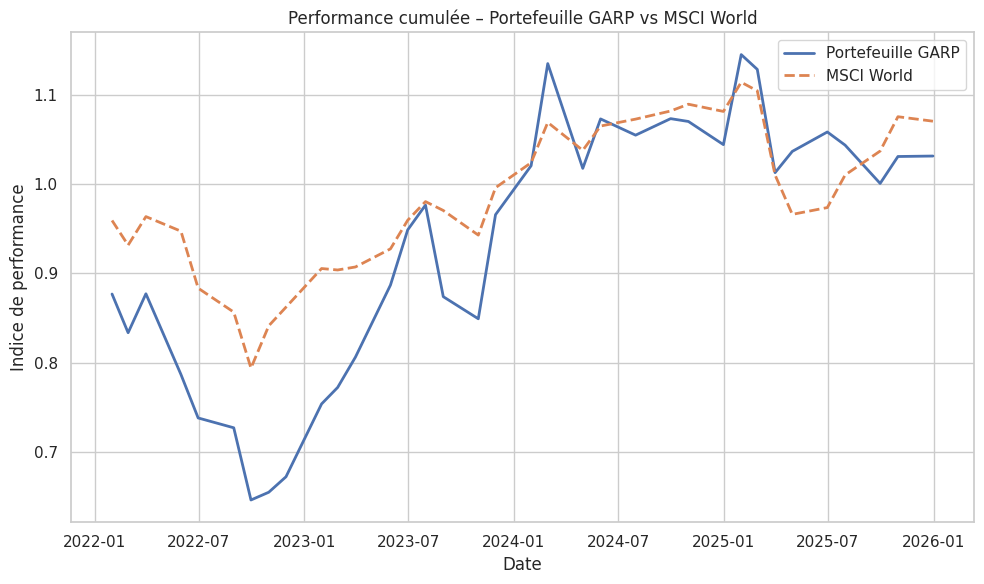

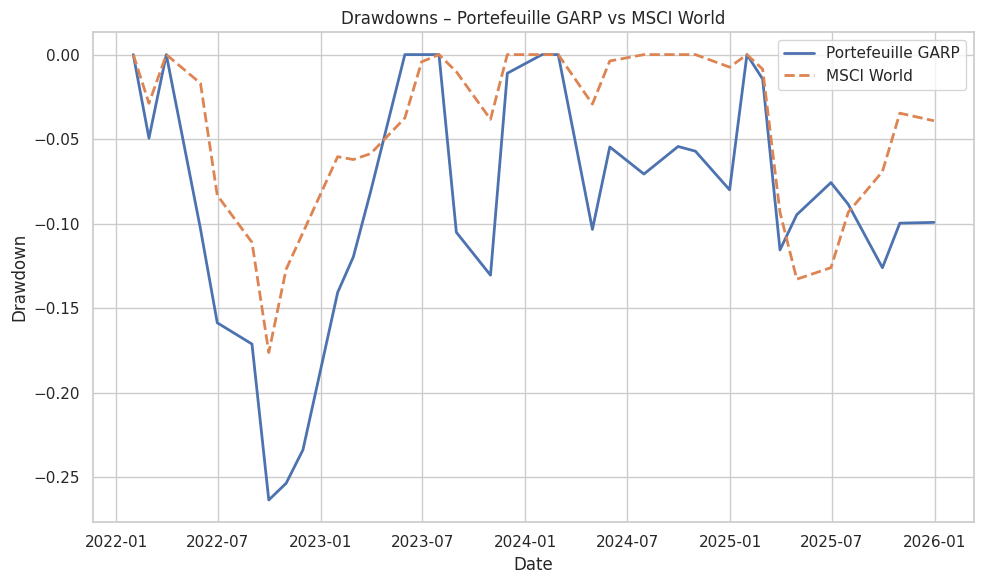

            Rendement annualisé  Volatilité annualisée  Ratio de Sharpe  \
GARP                   0.039374               0.242298         0.162501   
MSCI_World             0.031432               0.127192         0.247120   

            Drawdown maximum  
GARP               -0.263587  
MSCI_World         -0.176313  


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path

sns.set_theme(style="whitegrid")

# Définition des chemins
DATA_RAW = Path("../data/raw")
RESULTS_FIGURES = Path("../results/figures")
RESULTS_TABLES = Path("../results/tables")
RESULTS_FIGURES.mkdir(parents=True, exist_ok=True)
RESULTS_TABLES.mkdir(parents=True, exist_ok=True)

# --- Import MSCI World (FactSet), données mensuelles déjà en EUR ---
msci_world = pd.read_excel(DATA_RAW / "msci_world_factset.xlsx")

# Conversion et préparation des données MSCI World
msci_world.iloc[:, 0] = pd.to_datetime(msci_world.iloc[:, 0])
msci_world.set_index(msci_world.columns[0], inplace=True)
msci_world = msci_world.sort_index()
msci_world = msci_world.iloc[:, 0]
msci_world.name = "MSCI_World"

# Calcul des rendements logarithmiques mensuels MSCI World
r_msci_world = np.log(msci_world / msci_world.shift(1))

# Alignement temporel avec le portefeuille GARP (déjà chargé en mémoire)
returns_comp = pd.concat([garp_portfolio_returns, r_msci_world], axis=1, sort=False).dropna()
returns_comp.columns = ["GARP", "MSCI_World"]

# --- Calcul de la performance cumulée ---
cumulative_perf = (1 + returns_comp).cumprod()

# Graphique des performances cumulées
plt.figure(figsize=(10, 6))
plt.plot(cumulative_perf["GARP"], label="Portefeuille GARP", linewidth=2)
plt.plot(cumulative_perf["MSCI_World"], label="MSCI World", linestyle="--", linewidth=2)
plt.title("Performance cumulée – Portefeuille GARP vs MSCI World")
plt.xlabel("Date")
plt.ylabel("Indice de performance")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "performance_cumulee_garp_vs_msci_world.png")
plt.show()

# --- Calcul des drawdowns ---
rolling_max = cumulative_perf.cummax()
drawdown = cumulative_perf / rolling_max - 1

# Graphique des drawdowns
plt.figure(figsize=(10, 6))
plt.plot(drawdown["GARP"], label="Portefeuille GARP", linewidth=2)
plt.plot(drawdown["MSCI_World"], label="MSCI World", linestyle="--", linewidth=2)
plt.title("Drawdowns – Portefeuille GARP vs MSCI World")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "drawdowns_garp_vs_msci_world.png")
plt.show()

# --- Calcul des indicateurs de performance ---
perf_stats = pd.DataFrame(index=["GARP", "MSCI_World"])
perf_stats["Rendement annualisé"] = returns_comp.mean() * 12
perf_stats["Volatilité annualisée"] = returns_comp.std() * np.sqrt(12)
perf_stats["Ratio de Sharpe"] = (
    perf_stats["Rendement annualisé"] / perf_stats["Volatilité annualisée"]
)
perf_stats["Drawdown maximum"] = drawdown.min()

# Affichage des statistiques
print(perf_stats)

# Sauvegarde des statistiques au format CSV
perf_stats.to_csv(RESULTS_TABLES / "performance_stats_garp_vs_msci_world.csv")


## 3. Caractérisation stylistique du portefeuille — Comparaison avec MSCI World Growth et MSCI World Value

Cette section vise à comparer le profil de performance et de risque du portefeuille GARP avec les indices MSCI World Growth et MSCI World Value.

Les étapes réalisées sont :
- Import des indices MSCI World Growth et MSCI World Value (données mensuelles en EUR) depuis `data/raw` ;
- Alignement temporel avec le portefeuille GARP ;
- Calcul des rendements logarithmiques mensuels ;
- Calcul des performances cumulées, drawdowns, rendement annualisé, volatilité annualisée et ratio rendement/risque (Sharpe) pour chaque série ;
- Visualisation graphique et tableau comparatif ;
- Export des graphiques et des tableaux dans les dossiers `results/figures` et `results/tables`.


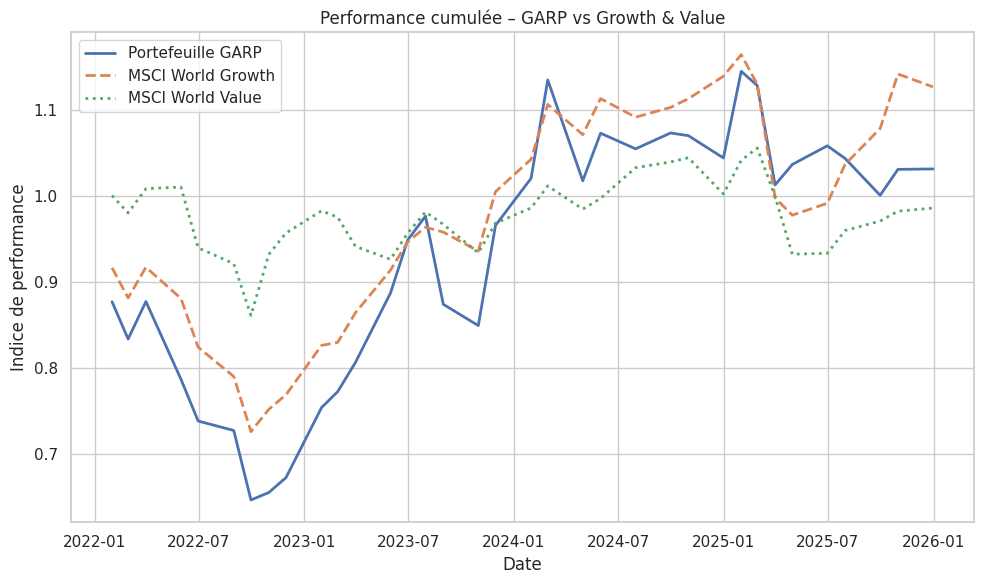

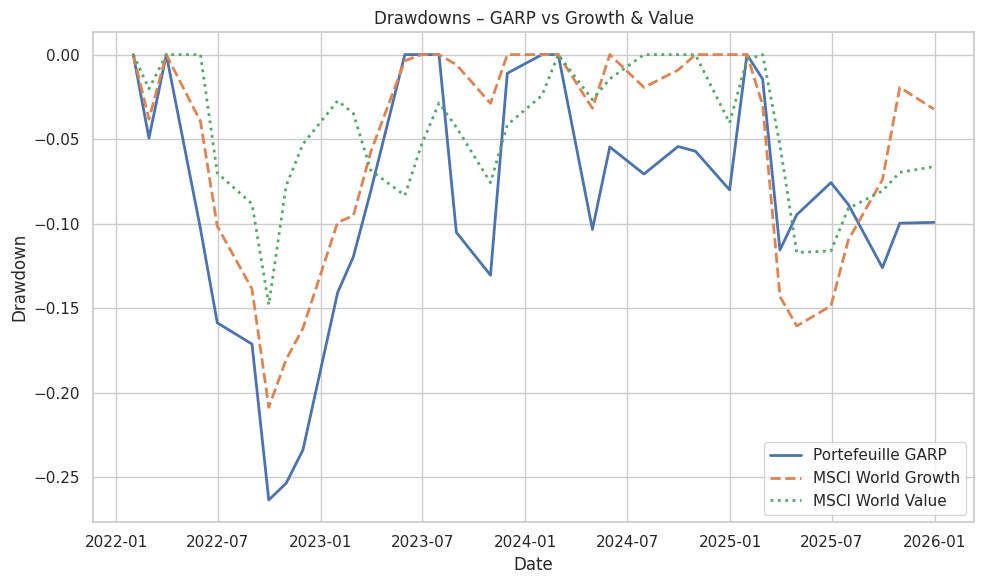

                   Rendement annualisé  Volatilité annualisée  \
GARP                          0.039374               0.242298   
MSCI_World_Growth             0.054305               0.163045   
MSCI_World_Value              0.002132               0.119131   

                   Ratio de Sharpe  Drawdown maximum  
GARP                      0.162501         -0.263587  
MSCI_World_Growth         0.333066         -0.208747  
MSCI_World_Value          0.017894         -0.148055  


In [9]:
# --- Import MSCI World Growth et MSCI World Value ---
msci_growth = pd.read_excel(Path("../data/raw/msci_world_growth_factset.xlsx"))
msci_value = pd.read_excel(Path("../data/raw/msci_world_value_factset.xlsx"))

# Préparation Growth
msci_growth.iloc[:, 0] = pd.to_datetime(msci_growth.iloc[:, 0])
msci_growth.set_index(msci_growth.columns[0], inplace=True)
msci_growth = msci_growth.sort_index()
msci_growth = msci_growth.iloc[:, 0]
msci_growth.name = "MSCI_World_Growth"

# Préparation Value
msci_value.iloc[:, 0] = pd.to_datetime(msci_value.iloc[:, 0])
msci_value.set_index(msci_value.columns[0], inplace=True)
msci_value = msci_value.sort_index()
msci_value = msci_value.iloc[:, 0]
msci_value.name = "MSCI_World_Value"

# --- Calcul des rendements logarithmiques ---
r_growth = np.log(msci_growth / msci_growth.shift(1))
r_value = np.log(msci_value / msci_value.shift(1))

# --- Alignement temporel avec le portefeuille GARP ---
returns_stylistic = pd.concat(
    [garp_portfolio_returns, r_growth, r_value], axis=1, sort=False
).dropna()
returns_stylistic.columns = ["GARP", "MSCI_World_Growth", "MSCI_World_Value"]

# --- Performances cumulées ---
cumulative_stylistic = (1 + returns_stylistic).cumprod()

# Graphique des performances cumulées
plt.figure(figsize=(10, 6))
plt.plot(cumulative_stylistic["GARP"], label="Portefeuille GARP", linewidth=2)
plt.plot(cumulative_stylistic["MSCI_World_Growth"], label="MSCI World Growth", linestyle="--", linewidth=2)
plt.plot(cumulative_stylistic["MSCI_World_Value"], label="MSCI World Value", linestyle=":", linewidth=2)
plt.title("Performance cumulée – GARP vs Growth & Value")
plt.xlabel("Date")
plt.ylabel("Indice de performance")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "performance_cumulee_garp_growth_value.png")
plt.show()

# --- Drawdowns ---
rolling_max_style = cumulative_stylistic.cummax()
drawdown_style = cumulative_stylistic / rolling_max_style - 1

# Graphique des drawdowns
plt.figure(figsize=(10, 6))
plt.plot(drawdown_style["GARP"], label="Portefeuille GARP", linewidth=2)
plt.plot(drawdown_style["MSCI_World_Growth"], label="MSCI World Growth", linestyle="--", linewidth=2)
plt.plot(drawdown_style["MSCI_World_Value"], label="MSCI World Value", linestyle=":", linewidth=2)
plt.title("Drawdowns – GARP vs Growth & Value")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_FIGURES / "drawdowns_garp_growth_value.png")
plt.show()

# --- Statistiques de performance ---
perf_stats_style = pd.DataFrame(index=["GARP", "MSCI_World_Growth", "MSCI_World_Value"])
perf_stats_style["Rendement annualisé"] = returns_stylistic.mean() * 12
perf_stats_style["Volatilité annualisée"] = returns_stylistic.std() * np.sqrt(12)
perf_stats_style["Ratio de Sharpe"] = perf_stats_style["Rendement annualisé"] / perf_stats_style["Volatilité annualisée"]
perf_stats_style["Drawdown maximum"] = drawdown_style.min()

# Affichage
print(perf_stats_style)

# Sauvegarde des statistiques
perf_stats_style.to_csv(RESULTS_TABLES / "performance_stats_garp_growth_value.csv")
